In [1]:
# Common packages
import numpy as np
import pandas as pd
import requests
import math
from astropy.constants import sigma_sb, L_sun
from bs4 import BeautifulSoup as BS
import itertools
import warnings
warnings.filterwarnings('ignore')

# Visuals
import matplotlib.pyplot as plt
import seaborn as sn
from matplotlib import cm

# Models
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, RandomForestRegressor, BaggingRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.svm import SVC

# Resampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import random

# Metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, accuracy_score
from sklearn.metrics import recall_score, precision_score, classification_report
from sklearn import metrics


In [2]:
# Read in final csv file from preprocessing
HZ_final = pd.read_csv('HZ_final.csv')

In [3]:
#Dropped the unnamed column
HZ_final = HZ_final.drop(columns = ['Unnamed: 0'])

In [5]:
#Selected the features for modeling 
features = ['pl_orbper_yrs', 'st_mass_x', 'sy_snum', 'sy_pnum',
       'pl_orbper', 'pl_orbsmax', 'st_rad_m']

In [6]:
# Selected target variable 
target = HZ_final.hab_zone

In [7]:
# Did test train split to test on all models
X_train, X_test, y_train, y_test = train_test_split(HZ_final[features], target, random_state=13 ,test_size=0.8)

# Creating Poly Features

In [8]:
# Created function to produce polynomial features 
def poly_df (df, degree):
    
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_data = poly.fit_transform(df)
    poly_columns = poly.get_feature_names(df.columns)
    HZ_poly = pd.DataFrame(poly_data, columns=poly_columns)
    return HZ_poly

In [9]:
# Created polynomial dataframe for test train split
HZ_poly  = poly_df(HZ_final[features], 2)

In [10]:
# Test train split for poly functions 
X_train_py, X_test_py, y_train_py, y_test_py = train_test_split(HZ_poly, target, random_state=13, test_size=0.8)

# Random Sampling

> Boostrap method

In [131]:
# Oversample the minority class by %25 
oversample = RandomOverSampler(sampling_strategy=0.25)

In [132]:
# Fit the X_train, y_train with the oversample
X_ov_tr, y_ov_tr = oversample.fit_sample(X_train, y_train)

In [15]:
# Fit the X_train and y_train poly with the oversanpling
X_over, y_over = oversample.fit_resample(X_train_py, y_train_py)

In [16]:
# Undersample of the majority class 
undersample = RandomUnderSampler(sampling_strategy='majority')

In [17]:
# Fit undersample with the poly features 
X_under, y_under = undersample.fit_resample(X_train_py, y_train_py)

In [18]:
# Get the weighted averages for the target class
weighted = HZ_final.hab_zone.value_counts(normalize=True)

In [19]:
# Create dictionary that zips the key and value pairs from the weighted averages
weighted = dict(zip(weighted.index, weighted.values))

In [21]:
# Rebalance weight classes, for minority class it is weighted more
weights_r = {1: 0.9763257575757576, 0: 0.023674242424242424}

In [22]:
# Minority class weighted 42 times more 
scal_pos = int(weights_r[1]/weights_r[0])

# Modeling

> Logistic Regression

In [23]:
# Create logistic model function that takes in train test split, and class weights given
# returns the F1 score and classification report 
def log_reg_model(X_train, y_train, X_test, y_test, weights = 'balanced'):
    logreg = LogisticRegression(class_weight = weights)
    logreg = logreg.fit(X_train, y_train)
    logreg_pred = logreg.predict(X_test)
    score = f1_score(y_test, logreg_pred, average ='binary')
    print("The F1 score for this model is {}".format(score))
    
    print("\nClassification report :\n",(classification_report(y_test, logreg_pred)))
    return(logreg_pred)

In [40]:
# confusion matrix plotter
# Takes in the target class, the predictions, classes, and plots based on color 
def plot_confusion_matrix(
    target,
    pred, 
    classes,
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.YlOrRd
):
    '''
    Function that prints and plots a model's confusion matrix.
    Input
    -----
    cm : sklearn confusion matrix
        `sklearn.metrics.confusion_matrix(y_true, y_pred)`
    classes : list (str)
        Names of target classes.
    Optional input
    --------------
    normalize : bool
        Whether to apply normalization (default=False).
        Normalization can be applied by setting `normalize=True`.
    title : str
        Title of the returned plot.
    cmap : matplotlib color map
        For options, visit:
        `https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html`
    Output
    ------
    Prints a stylized confusion matrix.
    '''
    # convert to percentage, if normalize set to True
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = confusion_matrix(target, pred)
    # plot
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    # format true positives and others
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize=16,
                 horizontalalignment="center", verticalalignment="center",
                 color="orange" if cm[i, j] > thresh else "black")
    # add axes labels
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

The F1 score for this model is 0.0

Classification report :
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3305
           1       0.00      0.00      0.00        75

    accuracy                           0.98      3380
   macro avg       0.49      0.50      0.49      3380
weighted avg       0.96      0.98      0.97      3380



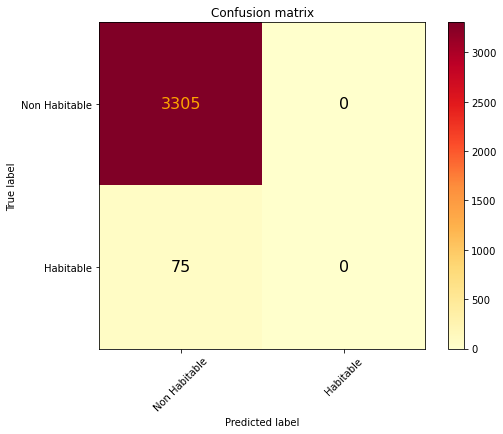

In [122]:
# Plots the confusion matrix with the model it is called on. 
plot_confusion_matrix(
    y_test,
    pred = log_reg_model(X_ov_tr, y_ov_tr, X_test, y_test),
    classes = ['Non Habitable', 'Habitable'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.YlOrRd
)

The F1 score for this model is 0.0

Classification report :
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3305
           1       0.00      0.00      0.00        75

    accuracy                           0.98      3380
   macro avg       0.49      0.50      0.49      3380
weighted avg       0.96      0.98      0.97      3380



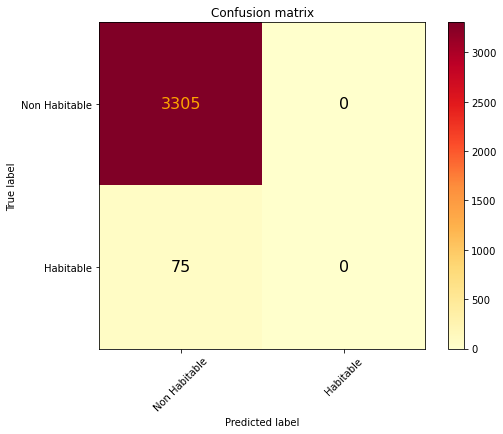

In [201]:
# Plots the confusion matrix with the model it is called on. 
# Using logistic regression with the weights
plot_confusion_matrix(
    y_test,
    pred = log_reg_model(X_train, y_train, X_test, y_test, weights=weights_r),
    classes = ['Non Habitable', 'Habitable'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.YlOrRd
)

The F1 score for this model is 0.0

Classification report :
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3305
           1       0.00      0.00      0.00        75

    accuracy                           0.98      3380
   macro avg       0.49      0.50      0.49      3380
weighted avg       0.96      0.98      0.97      3380



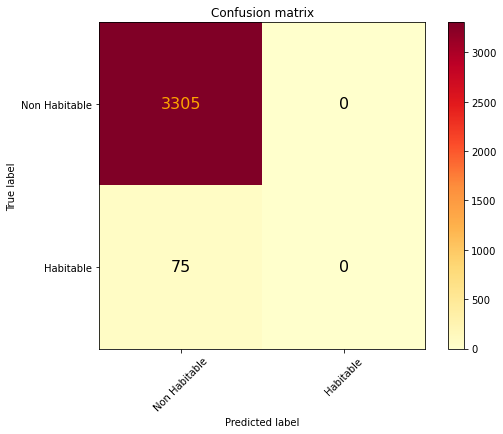

In [45]:
# Plots the confusion matrix with the model it is called on. 
# Logistic Regeression model with poly features and weights
plot_confusion_matrix(
    y_test,
    pred = log_reg_model(X_train_py, y_train, X_test_py, y_test, weights=weights_r),
    classes = ['Non Habitable', 'Habitable'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.YlOrRd
)

The F1 score for this model is 0.0

Classification report :
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3305
           1       0.00      0.00      0.00        75

    accuracy                           0.98      3380
   macro avg       0.49      0.50      0.49      3380
weighted avg       0.96      0.98      0.97      3380



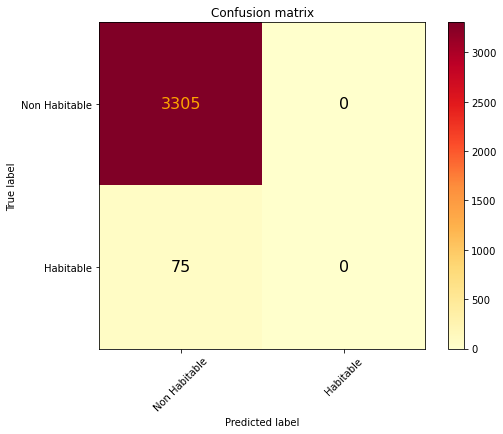

In [47]:
# Plots the confusion matrix with the model it is called on. 
# Undersampling of the minority class with weights 
plot_confusion_matrix(
    y_test,
    pred = log_reg_model(X_under, y_under, X_test_py, y_test, weights=weights_r),
    classes = ['Non Habitable', 'Habitable'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.YlOrRd
)

> Radnom Forest

In [29]:
# Created random forest function that takes in test train split, with
# n_estimators, max_depth paramteres given
def randomforest(X_train, y_train, X_test, y_test, est, depth, weights = 'balanced'):
    randfor = RandomForestClassifier(n_estimators = est, max_depth = depth, class_weight = weights, random_state = 13)
    randfor = randfor.fit(X_train, y_train)
    random_pred = randfor.predict(X_test)
    score = f1_score(y_test, random_pred)
    print("The F1 score for this model is {}".format(score))
    print ("\nClassification report Random Forest Classifier:\n",(classification_report(y_test, random_pred)))
    
    return(random_pred)

The F1 score for this model is 0.3711340206185567

Classification report Random Forest Classifier:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97      3305
           1       0.25      0.72      0.37        75

    accuracy                           0.95      3380
   macro avg       0.62      0.84      0.67      3380
weighted avg       0.98      0.95      0.96      3380



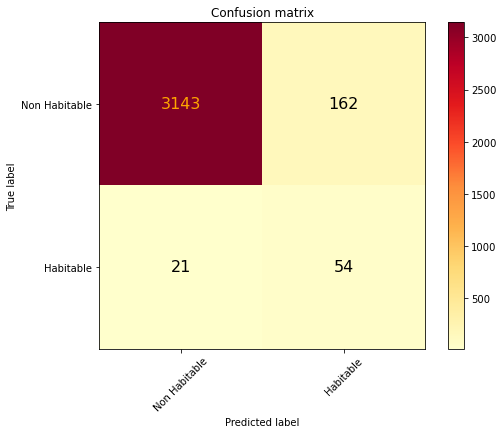

In [48]:
# Plot with random forest model, with given paramteres randomly chosen on test train split
plot_confusion_matrix(
    y_test,
    pred = randomforest(X_train, y_train, X_test, y_test, 20, 5),
    classes = ['Non Habitable', 'Habitable'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.YlOrRd
)

The F1 score for this model is 0.3917525773195877

Classification report Random Forest Classifier:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97      3305
           1       0.26      0.76      0.39        75

    accuracy                           0.95      3380
   macro avg       0.63      0.86      0.68      3380
weighted avg       0.98      0.95      0.96      3380



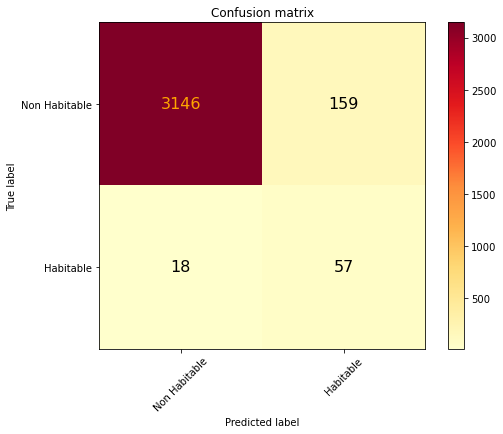

In [49]:
# Plot with random forest model, with given paramteres randomly chosen on test train split with weighted averages
plot_confusion_matrix(
    y_test,
    pred = randomforest(X_train, y_train, X_test, y_test, 20, 5, weights_r),
    classes = ['Non Habitable', 'Habitable'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.YlOrRd
)

The F1 score for this model is 0.30388692579505294

Classification report Random Forest Classifier:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97      3305
           1       0.21      0.57      0.30        75

    accuracy                           0.94      3380
   macro avg       0.60      0.76      0.64      3380
weighted avg       0.97      0.94      0.95      3380



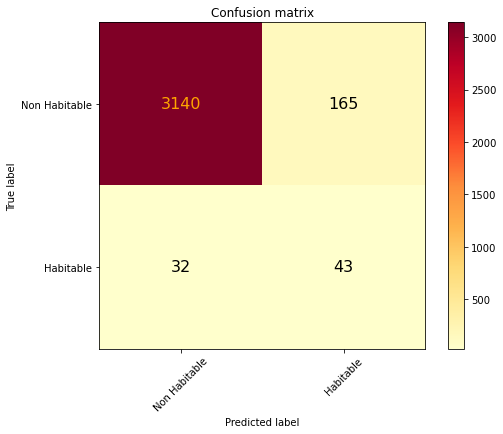

In [50]:
# Plot with random forest model, with given paramteres randomly chosen on test train split poly functions and 
# weighted averages 
plot_confusion_matrix(
    y_test,
    pred = randomforest(X_train_py, y_train_py, X_test_py, y_test, 20, 5, weights_r),
    classes = ['Non Habitable', 'Habitable'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.YlOrRd
)

> XGboost

In [33]:
# Created xgboost with train test split features and n_estimators, and max_depth parameters

def xgboost(X_train, y_train, X_test, y_test, est, depth ):
    xgb = XGBClassifier(n_estimators = est, max_depth = depth)
    xgb.fit(X_train, y_train)
    xgb_preds = xgb.predict(X_test)
    score = f1_score(y_test, xgb_preds)
    print("The F1 score for this model is {}".format(score))
    print ("\nClassification report Random Forest Classifier:\n",(classification_report(y_test, xgb_preds)))
    return(xgb_preds)
    

[13:15:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The F1 score for this model is 0.26

Classification report Random Forest Classifier:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3305
           1       0.52      0.17      0.26        75

    accuracy                           0.98      3380
   macro avg       0.75      0.58      0.62      3380
weighted avg       0.97      0.98      0.97      3380



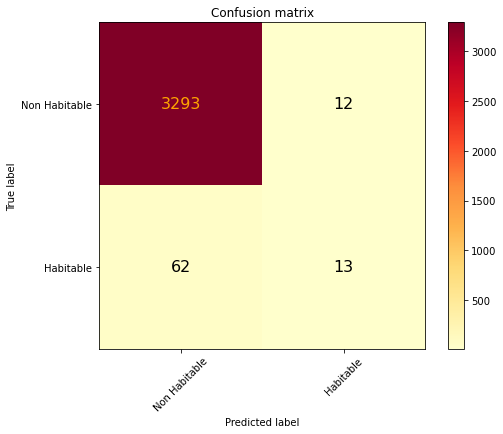

In [51]:
# Plot confusion matrix with test train split and random chosen parameters 
plot_confusion_matrix(
    y_test,
    pred = xgboost(X_train, y_train, X_test, y_test, 20, 5),
    classes = ['Non Habitable', 'Habitable'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.YlOrRd
)

[13:15:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The F1 score for this model is 0.13084112149532712

Classification report Random Forest Classifier:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      3305
           1       0.22      0.09      0.13        75

    accuracy                           0.97      3380
   macro avg       0.60      0.54      0.56      3380
weighted avg       0.96      0.97      0.97      3380



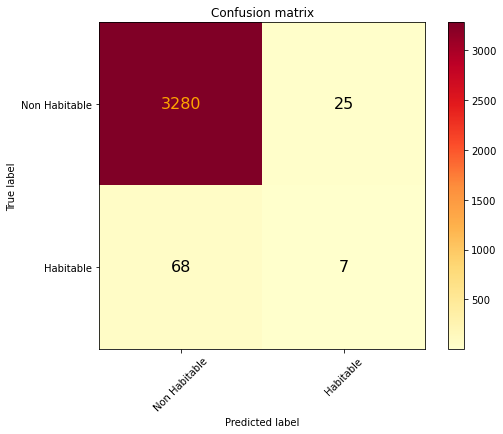

In [52]:
# Plot confusion matrix with test train split and random chosen parameters 
plot_confusion_matrix(
    y_test,
    pred = xgboost(X_train_py, y_train, X_test_py, y_test, 20, 5),
    classes = ['Non Habitable', 'Habitable'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.YlOrRd
)

> Light Gradient Boost

In [36]:
# Created Light GBM function which takles in x train test split parameters, given the 
# boosting type, num of leaves, max depth, learning rate, and class weight
def lightgb(X_train, y_train, X_test, y_test, weight = None):
    lgbm = lgb.LGBMClassifier(boosting_type='gbdt', 
                             num_leaves = 31, 
                             max_depth = 7, 
                             learning_rate = 0.5, 
                             class_weight = weight, 
                             random_state = 13,
                             n_jobs = -1)
    lgbm = lgbm.fit(X_train, y_train)
    lgb_pred = lgbm.predict(X_test)
    score = f1_score(y_test, lgb_pred)
    print("The F1 score for this model is {}".format(score))
    print ("\nClassification report Random Forest Classifier:\n",(classification_report(y_test, lgb_pred)))
    return(lgb_pred)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
The F1 score for this model is 0.26548672566371684

Classification report Random Forest Classifier:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      3305
           1       0.39      0.20      0.27        75

    accuracy                           0.98      3380
   macro avg       0.69      0.60      0.63      3380
weighted avg       0.97      0.98      0.97      3380



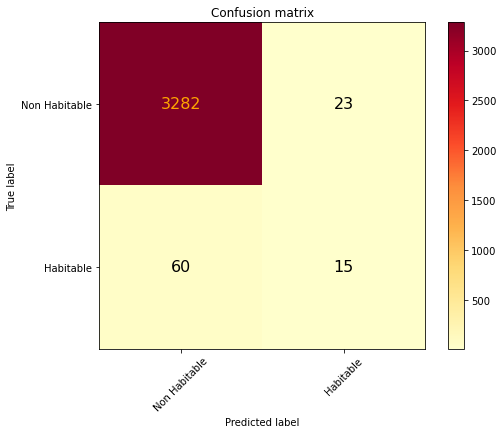

In [53]:
# Plot confusion matrix with train test split features
plot_confusion_matrix(
    y_test,
    pred = lightgb(X_train, y_train, X_test, y_test),
    classes = ['Non Habitable', 'Habitable'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.YlOrRd
)

> SVC

In [115]:
# Created SVC function passing in the test train split features 
# with the class weight and kernal chosen 
def svc(X_train, y_train, X_test, y_test):
    svc_mod = SVC(kernel = 'sigmoid',
                 class_weight = {1: 5, 0: 1})
    svc_mod = svc_mod.fit(X_train, y_train)
    svc_pred = svc_mod.predict(X_test)
    score = f1_score(y_test, svc_pred)
    print("The F1 score for this model is {}".format(score))
    print ("\nClassification report Random Forest Classifier:\n",(classification_report(y_test, svc_pred)))
    return(svc_pred)
    

The F1 score for this model is 0.052785923753665684

Classification report Random Forest Classifier:
               precision    recall  f1-score   support

           0       0.98      0.92      0.95      3305
           1       0.03      0.12      0.05        75

    accuracy                           0.90      3380
   macro avg       0.51      0.52      0.50      3380
weighted avg       0.96      0.90      0.93      3380



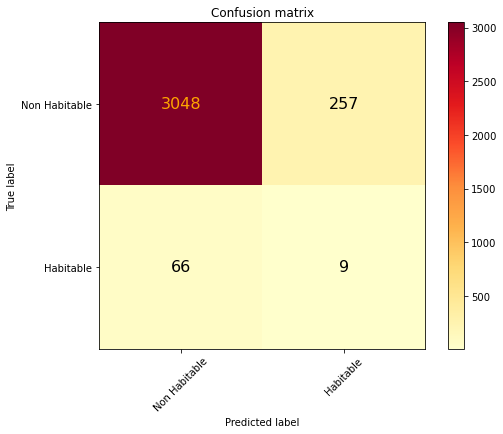

In [116]:
# Plot confusion matric with the SVC model 
plot_confusion_matrix(
    y_test,
    pred = svc(X_train, y_train, X_test, y_test),
    classes = ['Non Habitable', 'Habitable'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.YlOrRd
)

# Search best parameters:

> Grid Search with random forest

In [150]:
# Grid Search for Random forest given the criterion, max_depth, max_features, min_sample_leaf, 
# min_sample_leaf, n_estimators and class weights
rf_grid_search = {
    'criterion': ['gini'],
    'max_depth': [None, 1, 2, 3],
    'max_features': [None, 1, 2, 3],
    'min_samples_leaf': [None, 1, 2],
    'min_samples_split': [0, 1, 2, 3],
    'n_estimators': [100, 150, 200],
    'class_weight': [{1: 5, 0: 1}, {1: 10, 0: 1}, {1: 20, 0: 1}]
}

In [151]:
# Choose the model that the for the grid search 
rf = RandomForestClassifier()

# Perform grid search on the randomforest using all processors, choosing 3 fold cross validation 
grid_search = GridSearchCV(estimator = rf, param_grid = rf_grid_search, cv = 3, n_jobs = -1, verbose = 2)

In [152]:
# Fit grid search with Over sampling dataframe
grid_search.fit(X_ov_tr, y_ov_tr)

Fitting 3 folds for each of 1728 candidates, totalling 5184 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   57.8s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 5112 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 5184 out of 5184 | elapsed:  1.8min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 5}, {0: 1, 1: 10},
                                          {0: 1, 1: 20}],
                         'criterion': ['gini'], 'max_depth': [None, 1, 2, 3],
                         'max_features': [None, 1, 2, 3],
                         'min_samples_leaf': [None, 1, 2],
                         'min_samples_split': [0, 1, 2, 3],
                         'n_estimators': [100, 150, 200]},
             verbose=2)

In [153]:
# Shows the best parameters 
grid_search.best_params_

{'class_weight': {1: 5, 0: 1},
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 1,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [155]:
# New function for random forest with with the best features choosen from grid search 
def randomforestbest(X_train, y_train, X_test, y_test):
    randfor = RandomForestClassifier(criterion = 'gini' ,
                                     n_estimators = 100, 
                                     max_depth = None, 
                                     max_features = 1,
                                     min_samples_leaf = 1,
                                     min_samples_split = 2, 
                                     class_weight = {1: 5, 0: 1}, 
                                     random_state = 13)
    randfor = randfor.fit(X_train, y_train)
    random_pred = randfor.predict(X_test)
    score = f1_score(y_test, random_pred)
    print("The F1 score for this model is {}".format(score))
    print ("\nClassification report Random Forest Classifier:\n",(classification_report(y_test, random_pred)))
    
    return(random_pred)

The F1 score for this model is 0.26086956521739135

Classification report Random Forest Classifier:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      3305
           1       0.38      0.20      0.26        75

    accuracy                           0.97      3380
   macro avg       0.68      0.60      0.62      3380
weighted avg       0.97      0.97      0.97      3380



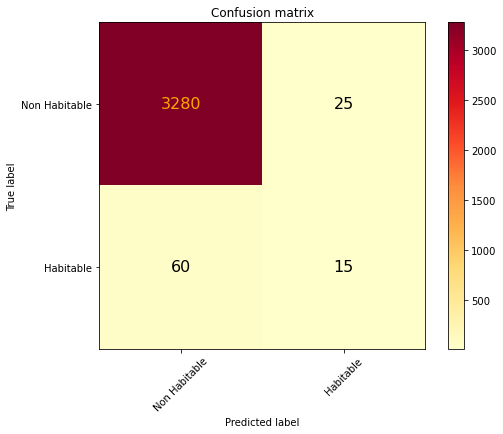

In [209]:
# Plot the confusion matrix with random forest based on the best parameters chosen from grid search 
plot_confusion_matrix(
    y_test,
    pred = randomforestbest(X_ov_tr, y_ov_tr, X_test, y_test),
    classes = ['Non Habitable', 'Habitable'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.YlOrRd
)

> Xgboost

In [197]:
# Grid Search parameters for Xgboost choosing, nthread, learning rate, max_depth, reg_alpha, 
# reg_lambda, subsample, n_estimators, booster, max_delt_step, and weight averages.  
xgb_params = { 'nthread': [3, 4, 5],
              'learning_rate': [0.023, 0.025, 0.028],
              'max_depth': [8, 9, 10],
              'reg_alpha': [1.09, 1.1, 1.11],
              'reg_lambda': [1.19, 1.2, 1.25],
              'subsample': [0.83, 0.84, 0.85],
              'n_estimators': [850, 900, 950],
              'booster': ['dart'],
              'max_delta_step': [0.1, 0.2, 0.3],
              'scale_pos_weight': [8, 9, 10]
}

In [198]:
# XGB classifier for grid search 
xgb = XGBClassifier()

In [199]:
# Perform a grid search on xgboost using all processors and 3 fold cross validation. 
xgb_grd_search = GridSearchCV(estimator = xgb, param_grid = xgb_params, cv = 3, n_jobs = -1, verbose =2)

In [200]:
# Grid Search performed on oversampled dataframe 
xgb_grd_search.fit(X_ov_tr, y_ov_tr)

Fitting 3 folds for each of 19683 candidates, totalling 59049 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 29.7min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 40.7min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 52.4min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed: 68.2min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 85.2min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed: 101.5min
[Parallel(n_jobs=-1)]: Done 5808 tasks      | elapsed: 119.4min
[Parallel(n_jobs=-1)]: Done 6821 tasks      | elapsed: 149.2min
[Parallel(n_jobs=-1)]: Done 7914 tasks      | elapsed: 177.7min
[Parallel(n_jobs=-1)]: Done 9089 tasks    

[15:27:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
             n_jobs=-1,
             param_grid={'booster': ['dart'],
                         'learning_rate': [0.023, 0.025, 0.028],
             

In [202]:
# Produce best parameters 
xgb_grd_search.best_params_

{'booster': 'dart',
 'learning_rate': 0.028,
 'max_delta_step': 0.3,
 'max_depth': 8,
 'n_estimators': 900,
 'nthread': 3,
 'reg_alpha': 1.09,
 'reg_lambda': 1.19,
 'scale_pos_weight': 8,
 'subsample': 0.83}

In [207]:
# Created function for xgboost best with the best parameters from grid search 
def xgboostbest(X_train, y_train, X_test, y_test):
    xgb = XGBClassifier(
                        learning_rate = 0.028,
                         booster = 'dart',
                        n_estimators = 900,
                        max_delta_step = 0.35,
                        max_depth = 8, 
                        nthread = 6, 
                        objective ='binary:logistic', 
                        reg_alpha = 1.11, 
                        reg_lambda = 1.19, 
                        subsample = 0.83, 
                        scale_pos_weight = 5
                    )
    xgb.fit(X_train, y_train)
    xgb_preds = xgb.predict(X_test)
    score = f1_score(y_test, xgb_preds)
    print("The F1 score for this model is {}".format(score))
    print ("\nClassification report Random Forest Classifier:\n",(classification_report(y_test, xgb_preds)))
    return(xgb_preds)

[16:00:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The F1 score for this model is 0.48044692737430167

Classification report Random Forest Classifier:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      3305
           1       0.41      0.57      0.48        75

    accuracy                           0.97      3380
   macro avg       0.70      0.78      0.73      3380
weighted avg       0.98      0.97      0.97      3380



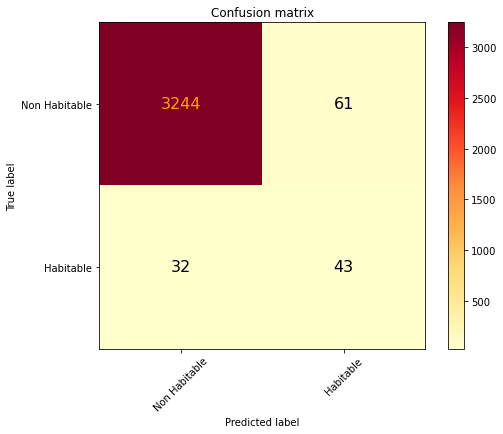

In [208]:
# Plotted the confusion matrix of xgboost using the best parameters given from grid search 
# Best model is xgboost 
plot_confusion_matrix(
    y_test,
    pred = xgboostbest(X_ov_tr, y_ov_tr, X_test, y_test),
    classes = ['Non Habitable', 'Habitable'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.YlOrRd
)

> Light GBM

In [210]:
# Created grid search parameters for light GBM model with n_estimators, boosting type, 
# sample by tree, max depth, number of leaves, min split gain, reg_alpha, reg_lambda, subsample 
# subsample frequency and class weights
lgbm_params = {'n_estimators': [240, 250, 255],
               'boosting': ['gbdt', 'dart'],
                'colsample_bytree': [0.69, 0.7, 0.71],
                'max_depth': [13, 15, 17],
                'num_leaves': [15, 20, 25, 30],
                'min_split_gain': [0.42, 0.4, 0.43],
                'reg_alpha': [1.0, 1.1],
                'reg_lambda': [1.45, 1.5],
                'subsample': [0.7, 0.75],
                'subsample_freq': [20],
                'class_weight': [{1: 28, 0: 1}, {1: 30, 0: 1}, {1: 32, 0: 1}] 
}

In [211]:
# Created lgbm classifier for grid search 
lgbm = lgb.LGBMClassifier()

In [212]:
# perform grid search on light GBM with all processors running and cross validation of 3 folds 
lgbm_grd_search = GridSearchCV(estimator = lgbm, param_grid = lgbm_params, cv = 3, n_jobs = -1, verbose =2)

In [213]:
# Perform grid search on Light GBM 
lgbm_grd_search.fit(X_train, y_train)

Fitting 3 folds for each of 15552 candidates, totalling 46656 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 288 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 1100 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 2232 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 3692 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 5472 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 7580 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 10008 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 12764 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 15840 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 19244 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 22968 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 25277 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 26370 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 27545 ta

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


GridSearchCV(cv=3, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'boosting': ['gbdt', 'dart'],
                         'class_weight': [{0: 1, 1: 28}, {0: 1, 1: 30},
                                          {0: 1, 1: 32}],
                         'colsample_bytree': [0.69, 0.7, 0.71],
                         'max_depth': [13, 15, 17],
                         'min_split_gain': [0.42, 0.4, 0.43],
                         'n_estimators': [240, 250, 255],
                         'num_leaves': [15, 20, 25, 30],
                         'reg_alpha': [1.0, 1.1], 'reg_lambda': [1.45, 1.5],
                         'subsample': [0.7, 0.75], 'subsample_freq': [20]},
             verbose=2)

In [ ]:
# Shows me the best parameters for Light GBM 
lgbm_grd_search.best_params_

In [70]:
#New function based on grid search for light GBM 
def lightgbest(X_train, y_train, X_test, y_test):
    lgbm = lgb.LGBMClassifier(colsample_bytree = 0.69,
                             boosting_type='gbdt', 
                             num_leaves = 15, 
                             min_split_gain = 0.4,
                             max_depth = 13,
                             n_estimators = 240, 
                             reg_alpha = 1.1,
                             reg_lambda = 1.5,
                             class_weight = {1: 30, 0: 1}, 
                             subsample = 0.7,
                             subsample_freq= 20)
    lgbm = lgbm.fit(X_train, y_train)
    lgb_pred = lgbm.predict(X_test)
    score = f1_score(y_test, lgb_pred)
    print("The F1 score for this model is {}".format(score))
    print ("\nClassification report Random Forest Classifier:\n",(classification_report(y_test, lgb_pred)))
    return(lgb_pred)

The F1 score for this model is 0.4150943396226415

Classification report Random Forest Classifier:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97      3305
           1       0.27      0.88      0.42        75

    accuracy                           0.94      3380
   macro avg       0.63      0.91      0.69      3380
weighted avg       0.98      0.94      0.96      3380



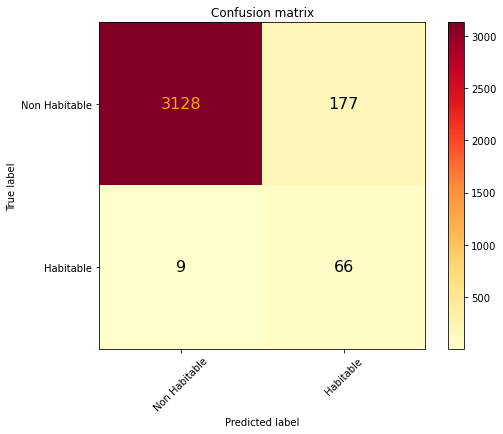

In [137]:
# Plot confusion matrix on light GBM model based on gridsearch 
plot_confusion_matrix(
    y_test,
    pred = lightgbest(X_ov_tr, y_ov_tr, X_test, y_test),
    classes = ['Non Habitable', 'Habitable'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.YlOrRd
)

> SVM

In [139]:
# Created grid search parameters for SVM using kernel types, gamma, C, and class weights 
svc_params = { 'kernel': ['rbf', 'sigmoid', 'poly'],
              'gamma': [1, .1, 0.01, 1e-3, 1e-4],
              'C': [0.001, 0.0001, 0.01, 0.1, 1],
              'class_weight': [{1: 5, 0: 1}, {1: 8, 0: 1}, {1: 10, 0: 1}, {1: 12, 0: 1}] 
                }

In [140]:
# Created SVC model 
svm = SVC()

In [141]:
# Performed Grid Search on SVC with all processors and cross validation of 3 fold
svm_grd_search = GridSearchCV(estimator = svm, param_grid = svc_params, cv = 3, n_jobs = -1, verbose =2)

In [142]:
# Performed Grid Search on SVM with overfit dataframe 
svm_grd_search.fit(X_ov_tr, y_ov_tr)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 360 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    4.4s finished


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.001, 0.0001, 0.01, 0.1, 1],
                         'class_weight': [{0: 1, 1: 5}, {0: 1, 1: 8},
                                          {0: 1, 1: 10}, {0: 1, 1: 12}],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['sigmoid', 'poly']},
             verbose=2)

In [143]:
# Shows the best parameters from Grid Search based SVC model 
svm_grd_search.best_params_

{'C': 0.001, 'class_weight': {1: 5, 0: 1}, 'gamma': 1, 'kernel': 'sigmoid'}

In [135]:
# Created SVC best function that picks the best features from grif search to perform on the SVM model 
def svcbest(X_train, y_train, X_test, y_test):
    svc_mod = SVC(kernel = 'sigmoid',
                  gamma = 1,
                  C = 0.001,
                  class_weight = {1: 5, 0: 1})
    svc_mod = svc_mod.fit(X_train, y_train)
    svc_pred = svc_mod.predict(X_test)
    score = f1_score(y_test, svc_pred)
    print("The F1 score for this model is {}".format(score))
    print ("\nClassification report Random Forest Classifier:\n",(classification_report(y_test, svc_pred)))
    return(svc_pred)
    

The F1 score for this model is 0.04341534008683068

Classification report Random Forest Classifier:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      3305
           1       0.02      1.00      0.04        75

    accuracy                           0.02      3380
   macro avg       0.01      0.50      0.02      3380
weighted avg       0.00      0.02      0.00      3380



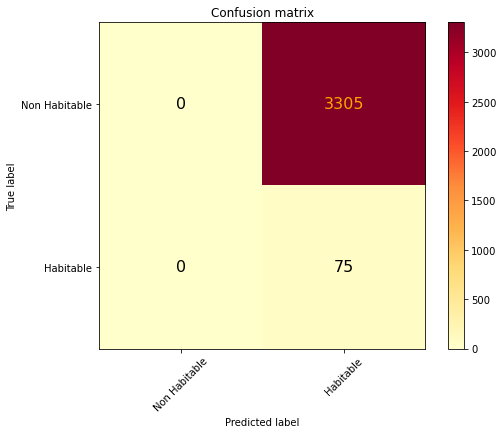

In [136]:
# Plot confision matric on the SVC model based on grid search 
# Worst performing model
plot_confusion_matrix(
    y_test,
    pred = svcbest(X_ov_tr, y_ov_tr, X_test, y_test),
    classes = ['Non Habitable', 'Habitable'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.YlOrRd
)